In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from datetime import datetime
import xarray as xr
import sys
import netCDF4 as nc
from rasterio.transform import Affine
import rasterio as rio
import datetime as dt
from netCDF4 import date2num,num2date

In [2]:
#api_auth = '/home/tyler/.api_request'
api_auth = '/home/patrick/.api_user_pass'
url = "https://forecasting.energy.arizona.edu/erebos/series/adjghi"
path = "/home/patrick/git_repos/Short-Term-GHI-Prediction/"

In [3]:
##### Below is the function for developing a 9x9 grid of ghi estimated values from EREBOS 

## central_lon: longitude of the location in which you are forecasting
## central_lat: latitude of the location in which you are forecasting 
## year: the year of the forecast date/time
## month: the month of the forecast date/time
## day: the day of the forecast date/time
## hour: the (initital) hour of the forecast date/time
## minute_start: the starting minute of the forecast date/time (needs to be 2,7,12,17,22,27,32,37,42,47,52,57 only)
## minute_end: the ending minute of the forecast date/time (needs to be 2,7,12,17,22,27,32,37,42,47,52,57 only)
## new_hour: set to false, however when true will reset the minutes and add an hour once the loop is greater than 57 mins.


##### Work flow
### Part 1 of the function:
## a 9x9 grid of latitude and longitude is created which will be centered around the central lats and lons specified 

### Part 2 of the function:
## a double for loop is used to loop through all 81 lat lon grid points
## an API request is sent using the year, month, day, lat, and lon arguments specified
## ghi values are obtained at all lat lon points and appended into a pandas dataframe
## start and end dates are created based off of the year, month, day, hour, and mins specified
## if new_hour is true, the hour is increased by 1 for the end date
## the dataframe is then sliced based off of the start and end dates specified
## the rest of part 2 is creating a netcdf (nc) file of the data

### Part 3 of the function:
## all that is done in this part is taking the data from the netcdf file and creating a raster file 

In [7]:
def grid_maker(central_lon=None, central_lat=None, tznow=None, grid_size=None, images_num=None):
    """
    
    Function to set up grid around forecast site and retrieve 
    timeseries erobos data for each point on the grid
    
    Parameters
    ----------
    central_lon : float
        longitude for central point of forecast domain
    central_lat : float
        latitude for central point of forecast domain
    tznow : str
        date and time to initilize forecast
    grid_size : int
        size of grid to make around central lat,lon. Must be 
        an odd number
    images_num : number of Erebos "images" used to lookback 
        and make forecast with. Approximately one GOES image 
        per 5 minute period. Default should be about 6 images
        equating to ~30 mins.
    
    Returns
    ----------
    
    Array of ghi images, 
    datetime index for each image,
    latitudes of grid,
    longitudes of grid
            
    """
    dx = 0.009    # defined by erobos horizontal resolution, 0.0009 degrees
    dy = 0.009    
    lons = np.arange(central_lon-int(grid_size/2)*dx, central_lon+int(grid_size/2)*dx, dx)
    lats = np.arange(central_lat-int(grid_size/2)*dy, central_lat+int(grid_size/2)*dy, dy)             
    print('dimensions should match', grid_size, len(lats))
          
    req_end   = pd.Timestamp(tznow)
    req_start = req_end - pd.Timedelta(str(images_num*5)+'T')
    
    print(req_start,req_end)

    ghi_array = np.empty((images_num,grid_size,grid_size))
    
    for i in range(len(lats)):
        for j in range(len(lons)):
            args = {'run_date':'{0}-{1}-{2}'.format(req_start.year,req_start.month,req_start.day), 
                    'lon':'{}'.format(lons[j]),
                    'lat':'{}'.format(lats[i]),
                    'precipitable_water':'1.00',
                    'aod700':'0.05'}
            with open(api_auth) as f:
                auth_text = f.read()
            auth_tuple = tuple(auth_text.split('\n'))[:2]
            req = requests.get(url, params=args, auth=auth_tuple)
            
            df = pd.DataFrame(req.json())
            df.index = pd.to_datetime(df.index)
            
            subset = df.loc[req_start:req_end]
            index = subset.index
            ghi_array[:,i,j] = subset['results']

    return ghi_array, index, lons, lats

In [8]:
ghi_array, index, lons, lats = grid_maker(central_lon=-112.965, central_lat=32.915, 
                              tznow='2020-03-01 T18:42Z', 
                              grid_size=9, images_num=6)

dimensions should match 9 9
2020-03-01 18:12:00+00:00 2020-03-01 18:42:00+00:00


In [29]:
def create_tiffs(ghi_array, index, lons, lats):
        
    ## calculate transform variable to create raster data

    res = (lons[-1] - lons[0]) / 240.0
    transform = Affine.translation(lons[0] - res / 2, lats[0] - res / 2) * Affine.scale(res, res)
    
    # open in 'write' mode, unpack profile info to dst
    ## Create raster file
    for t in range(len(ghi_array[:,0,0])):
        ghi_image = ghi_array[t,:,:]
        with rio.open(
           'erebos_grid_'+index[t].strftime('%Y-%m-%d_%H_%M')+'.tiff',
           "w",
           driver="GTiff",         # output file type
           height=ghi_image.shape[0],      # shape of array
           width=ghi_image.shape[1],
           count=1,                # number of bands
           dtype=ghi_image.dtype,          # output datatype
           crs="+proj=latlong",    # CRS
           transform=transform,    # location and resolution of upper left cell
        ) as dst:
           # check for number of bands
           if dst.count == 1:
               # write single band
               dst.write(ghi_image, 1)
           else:
               # write each band individually
               for band in range(len(ghi_image)):
                   # write data, band # (starting from 1)
                   dst.write(ghi_image[band], band + 1)
          
    return "tiff files created"

In [30]:
create_tiffs(ghi_array, index, lons, lats)

'tiff files created'

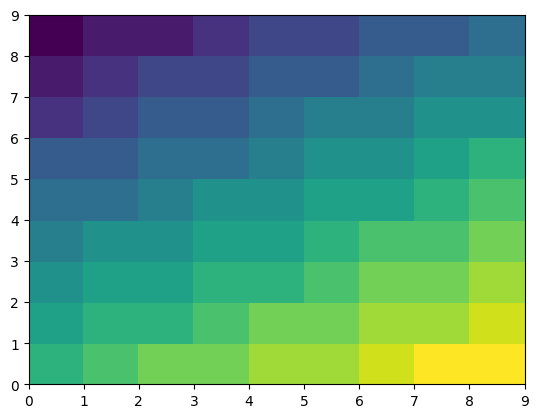

In [20]:
plt.pcolormesh(ghi_array[0,:,:])
plt.show()

In [32]:
tiff1 = rio.open('/home/patrick/git_repos/Short-Term-GHI-Prediction/erebos_grid_2020-03-01_18_12.tiff')
file1 = tiff1.read(1)

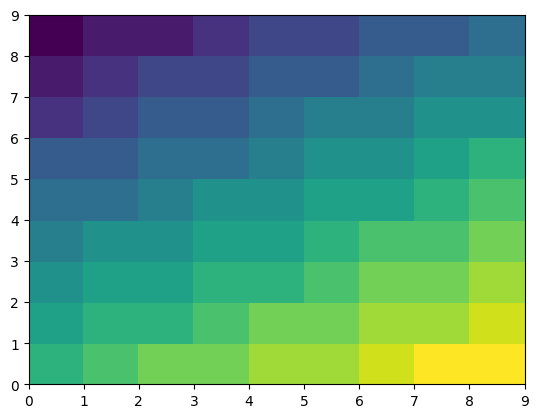

In [34]:
plt.pcolormesh(file1)
